In [53]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D

In [46]:
# Load conspiracy and non-conspiracy node data
conspiracy_node_paths = ['5G-Graphs/63/nodes.csv','5G-Graphs/99/nodes.csv','5G-Graphs/124/nodes.csv',
              '5G-Graphs/144/nodes.csv','5G-Graphs/157/nodes.csv','5G-Graphs/176/nodes.csv',
              '5G-Graphs/192/nodes.csv', '5G-Graphs/203/nodes.csv','5G-Graphs/205/nodes.csv',
              '5G-Graphs/217/nodes.csv', '5G-Graphs/220/nodes.csv', '5G-Graphs/251/nodes.csv',
              '5G-Graphs/256/nodes.csv', '5G-Graphs/270/nodes.csv', '5G-Graphs/275/nodes.csv',
              '5G-Graphs/283/nodes.csv', '5G-Graphs/286/nodes.csv', '5G-Graphs/306/nodes.csv',
              '5G-Graphs/308/nodes.csv', '5G-Graphs/313/nodes.csv', '5G-Graphs/315/nodes.csv',
              '5G-Graphs/320/nodes.csv', '5G-Graphs/322/nodes.csv', '5G-Graphs/325/nodes.csv',
              '5G-Graphs/330/nodes.csv', '5G-Graphs/334/nodes.csv', '5G-Graphs/345/nodes.csv', 
              '5G-Graphs/407/nodes.csv', '5G-Graphs/409/nodes.csv', '5G-Graphs/410/nodes.csv']

nonconspiracy_node_paths = ['non-conspiracy/38/nodes.csv', 'non-conspiracy/157/nodes.csv', 'non-conspiracy/241/nodes.csv',
              'non-conspiracy/799/nodes.csv', 'non-conspiracy/845/nodes.csv', 'non-conspiracy/847/nodes.csv',
              'non-conspiracy/862/nodes.csv','non-conspiracy/898/nodes.csv', 'non-conspiracy/968/nodes.csv',
              'non-conspiracy/1002/nodes.csv', 'non-conspiracy/1036/nodes.csv', 'non-conspiracy/1097/nodes.csv',
              'non-conspiracy/1520/nodes.csv', 'non-conspiracy/1660/nodes.csv', 'non-conspiracy/1706/nodes.csv',
              'non-conspiracy/1886/nodes.csv', 'non-conspiracy/1937/nodes.csv', 'non-conspiracy/1948/nodes.csv',
              'non-conspiracy/1950/nodes.csv', 'non-conspiracy/2366/nodes.csv'
              ]


In [47]:
# Load conspiracy and non-conspiracy edge data
conspiracy_edge_paths = ['5G-Graphs/63/edges.txt','5G-Graphs/99/edges.txt','5G-Graphs/124/edges.txt',
              '5G-Graphs/144/edges.txt','5G-Graphs/157/edges.txt','5G-Graphs/176/edges.txt',
              '5G-Graphs/192/edges.txt', '5G-Graphs/203/edges.txt','5G-Graphs/205/edges.txt',
              '5G-Graphs/217/edges.txt', '5G-Graphs/220/edges.txt', '5G-Graphs/251/edges.txt',
              '5G-Graphs/256/edges.txt', '5G-Graphs/270/edges.txt', '5G-Graphs/275/edges.txt',
              '5G-Graphs/283/edges.txt', '5G-Graphs/286/edges.txt', '5G-Graphs/306/edges.txt',
              '5G-Graphs/308/edges.txt', '5G-Graphs/313/edges.txt', '5G-Graphs/315/edges.txt',
              '5G-Graphs/320/edges.txt', '5G-Graphs/322/edges.txt', '5G-Graphs/325/edges.txt',
              '5G-Graphs/330/edges.txt', '5G-Graphs/334/edges.txt', '5G-Graphs/345/edges.txt', 
              '5G-Graphs/407/edges.txt', '5G-Graphs/409/edges.txt', '5G-Graphs/410/edges.txt',
              ]

nonconspiracy_edge_paths = ['non-conspiracy/38/edges.txt', 'non-conspiracy/157/edges.txt', 'non-conspiracy/241/edges.txt',
              'non-conspiracy/799/edges.txt', 'non-conspiracy/845/edges.txt', 'non-conspiracy/847/edges.txt',
              'non-conspiracy/862/edges.txt','non-conspiracy/898/edges.txt', 'non-conspiracy/968/edges.txt',
              'non-conspiracy/1002/edges.txt', 'non-conspiracy/1036/edges.txt', 'non-conspiracy/1097/edges.txt',
              'non-conspiracy/1520/edges.txt', 'non-conspiracy/1660/edges.txt', 'non-conspiracy/1706/edges.txt',
              'non-conspiracy/1886/edges.txt', 'non-conspiracy/1937/edges.txt', 'non-conspiracy/1948/edges.txt',
              'non-conspiracy/1950/edges.txt', 'non-conspiracy/2366/edges.txt'
              ]

In [48]:
# SI model function
def si_model(y, t, beta):
    S, I = y
    dSdt = -beta * S * I
    dIdt = beta * S * I
    return [dSdt, dIdt]

In [65]:
# Make font size on plots larger, for better visibility on the final paper
plt.rcParams.update({
    'font.size': 12,        # Default font size
    'axes.titlesize': 16,   # Title font
    'axes.labelsize': 14,   # Axis label font
    'xtick.labelsize': 12,  # X tick label
    'ytick.labelsize': 12,  # Y tick label
    'legend.fontsize': 12   # Legend font
})

In [66]:
# Simulation and plotting function for SI dynamics
# Plots fraction of infected individuals over time
def simulate_and_plot(node_paths, beta, title):
    plt.figure(figsize=(12, 6))  # Set up a new figure for the group of subgraphs

    for path in node_paths:
        try:
            # Load node CSV containing tweet timestamps
            df = pd.read_csv(path)

            # Extract non-null tweet times
            times = df['time'].dropna().values
            if len(times) < 2:
                # Skip graphs with too little data to simulate meaningfully
                continue

            # Normalize time so the first tweet starts at time 0 (not technically necessary)
            times = times - np.min(times)
            max_time = np.max(times)  # Use to scale time range for simulation

            # Initialize population state: 1 infected (time=0), rest susceptible
            N = len(df)
            initial_I = 1 / N                # One initially infected individual
            initial_S = 1 - initial_I        # Everyone else is susceptible
            init_vals = [initial_S, initial_I]

            # Simulate SI dynamics over the time range of the data
            t_vals = np.linspace(0, max_time, 200)  # 200 time steps between 0 and max_time
            sim = odeint(si_model, init_vals, t_vals, args=(beta,))  # Solve the ODEs

            # Plot the infected fraction over time (I(t))
            plt.plot(t_vals, sim[:, 1], alpha=0.6)  # sim[:, 1] corresponds to I(t)

        except Exception as e:
            # Gracefully handle missing or broken files
            print(f"Error processing {path}: {e}")
            continue

    # Limit x-axis for clarity because most graphs have long tails
    plt.xlim(0, 1e5)

    # Plot formatting
    plt.xlabel("Time (seconds since first tweet)")
    plt.ylabel("Fraction Infected I(t)")
    plt.title(title)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


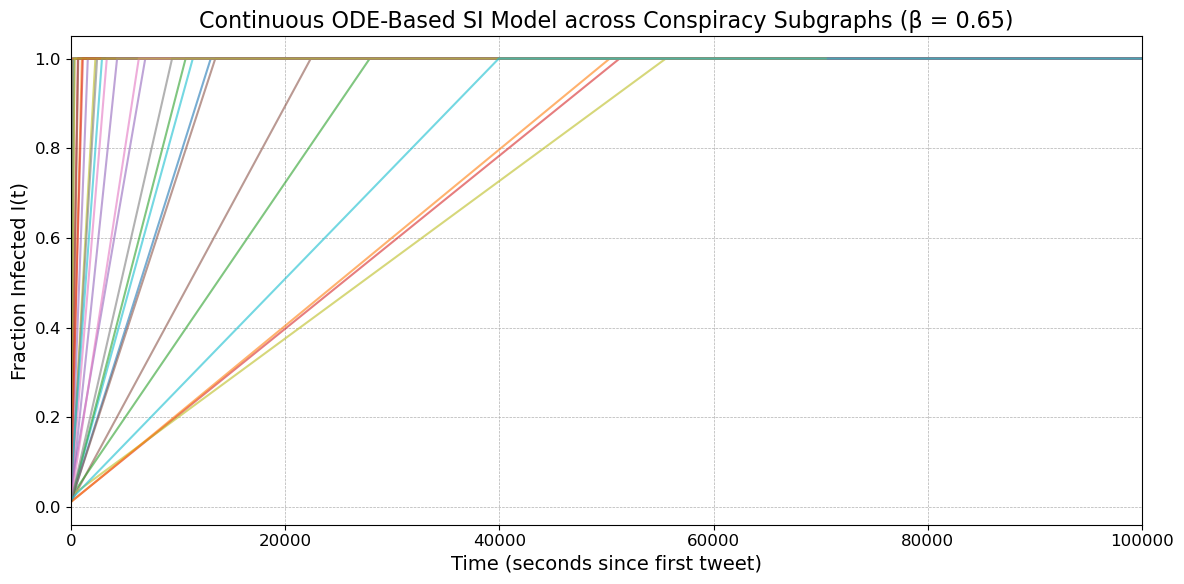

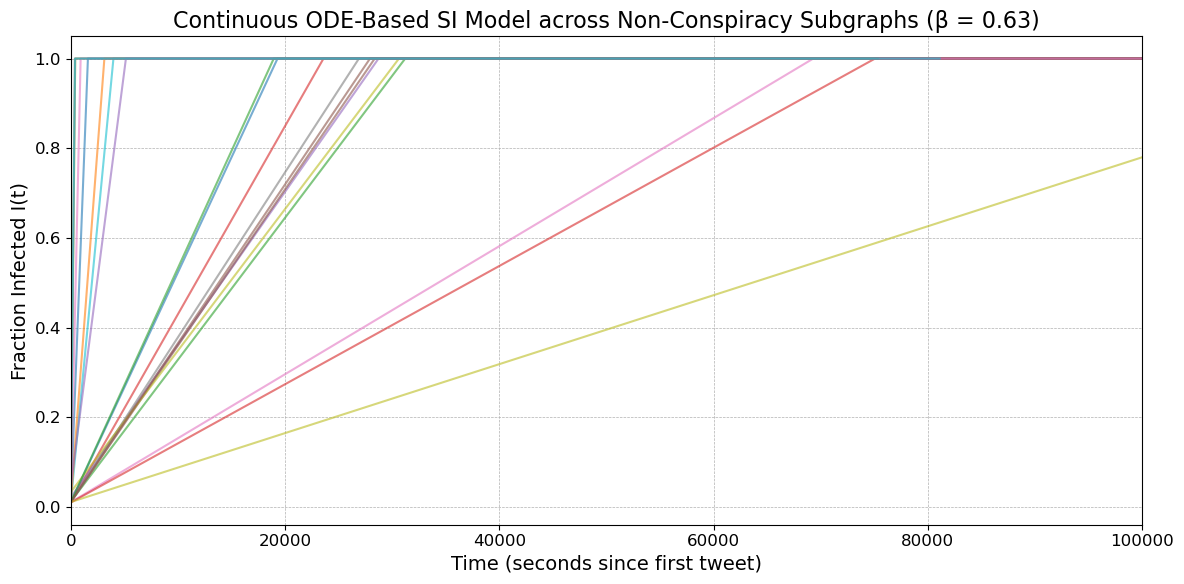

In [67]:
# Function call
simulate_and_plot(conspiracy_node_paths, beta=0.65,
                  title="Continuous ODE-Based SI Model across Conspiracy Subgraphs (β = 0.65)")

simulate_and_plot(nonconspiracy_node_paths, beta=0.63,
                  title="Continuous ODE-Based SI Model across Non-Conspiracy Subgraphs (β = 0.63)")

In [68]:
# Simulation and plotting function for SI dynamics
# Plots fraction of susceptible and infected individuals over time
def simulate_and_plot(node_paths, beta, title):
    plt.figure(figsize=(12, 6))  # Create a new figure for plotting

    N = len(node_paths)  # Total number of diffusion graphs to simulate

    # Load colormaps for matched shades of red (Infected) and blue (Susceptible)
    red_map = get_cmap("Reds")
    blue_map = get_cmap("Blues")

    # Choose color shades evenly spaced between 0.3 and 0.9 (avoid very light/dark extremes)
    color_indices = np.linspace(0.3, 0.9, N)

    for i, path in enumerate(node_paths):
        try:
            # Load node data from CSV
            df = pd.read_csv(path)

            # Drop missing times and extract time values
            times = df['time'].dropna().values
            if len(times) < 2:
                # Skip files with insufficient data
                continue

            # Normalize tweet times so first tweet starts at time 0
            times = times - np.min(times)
            max_time = np.max(times)

            # Create time values for simulation
            t_vals = np.linspace(0, max_time, 200)

            # Initialize SI model: 1 infected (time=0), rest susceptible
            N_nodes = len(df)
            init_vals = [1 - 1/N_nodes, 1/N_nodes]  # [S0, I0]

            # Solve ODE system using odeint
            sim = odeint(si_model, init_vals, t_vals, args=(beta,))

            # Select matching colors from colormap
            blue = blue_map(color_indices[i])  # For Susceptible
            red = red_map(color_indices[i])    # For Infected

            # Plot Susceptible and Infected fractions with matching shades
            plt.plot(t_vals, sim[:, 0], color=blue, alpha=0.6)  # S(t)
            plt.plot(t_vals, sim[:, 1], color=red, alpha=0.6)   # I(t)

        except Exception as e:
            # Gracefully handle any file read or processing errors
            print(f"Error with {path}: {e}")
            continue

    # Limit x-axis to early dynamics for visibility
    plt.xlim(0, 1e5)

   # Plot formatting
    plt.xlabel("Time (seconds since first tweet)")
    plt.ylabel("Fraction of Population")
    plt.title(title)
    plt.grid(True, linestyle="--", linewidth=0.5)

    # Define custom legend handles
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Susceptible'),
        Line2D([0], [0], color='red', lw=2, label='Infected')
    ]

    # Add legend to plot
    plt.legend(handles=legend_elements, loc='upper right')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


/var/folders/vf/_6h12gpn5_15tp2p642gtz5m0000gn/T/ipykernel_53218/1543120970.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  red_map = get_cmap("Reds")
/var/folders/vf/_6h12gpn5_15tp2p642gtz5m0000gn/T/ipykernel_53218/1543120970.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blue_map = get_cmap("Blues")


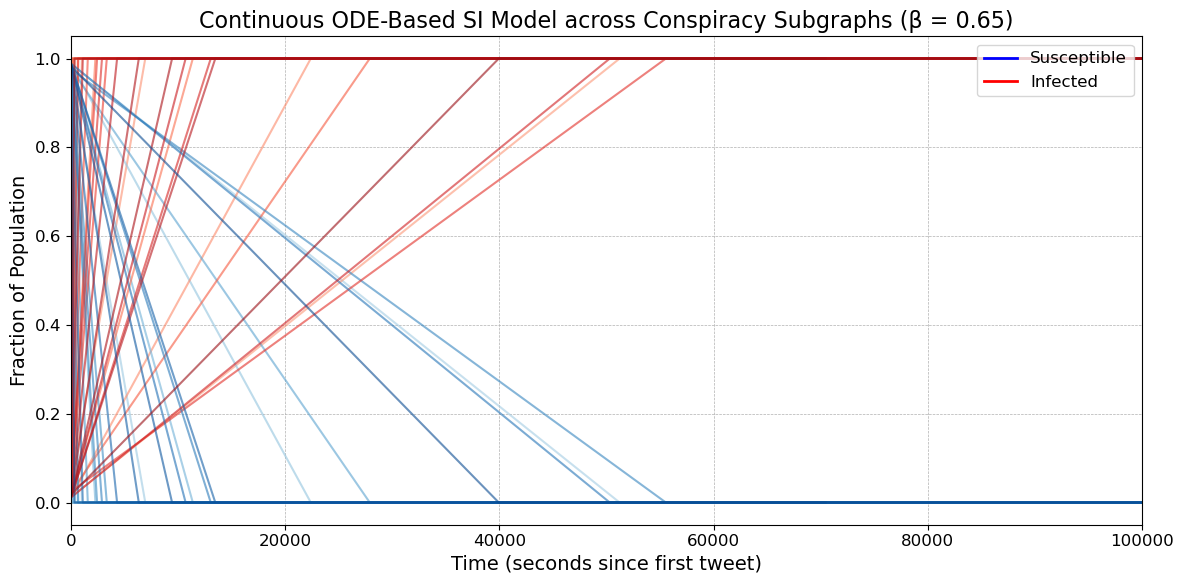

/var/folders/vf/_6h12gpn5_15tp2p642gtz5m0000gn/T/ipykernel_53218/1543120970.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  red_map = get_cmap("Reds")
/var/folders/vf/_6h12gpn5_15tp2p642gtz5m0000gn/T/ipykernel_53218/1543120970.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blue_map = get_cmap("Blues")


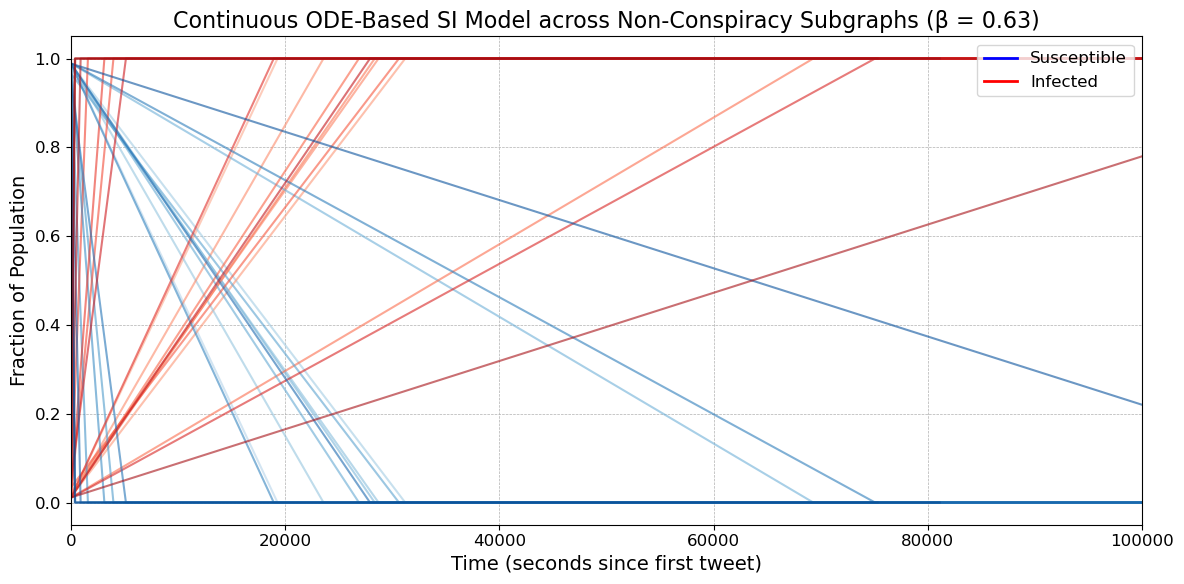

In [69]:
# Function calls
simulate_and_plot(conspiracy_node_paths, beta=0.65,
                  title="Continuous ODE-Based SI Model across Conspiracy Subgraphs (β = 0.65)", )

simulate_and_plot(nonconspiracy_node_paths, beta=0.63,
                  title="Continuous ODE-Based SI Model across Non-Conspiracy Subgraphs (β = 0.63)")

In [70]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.cm import get_cmap

# Network-based SI simulation function
def simulate_SI_network(G, beta, initial_infected):
    infected = set([initial_infected])
    susceptible = set(G.nodes()) - infected
    time_series = [len(infected) / len(G)]

    while susceptible:
        new_infected = set()
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and random.random() < beta:
                    new_infected.add(neighbor)
        if not new_infected:
            break
        infected.update(new_infected)
        susceptible -= new_infected
        time_series.append(len(infected) / len(G))
    return time_series

# Function to simulate and plot network-based SI dynamics
def simulate_and_plot_network(node_paths, beta, title):
    plt.figure(figsize=(12, 6))
    red_map = get_cmap("Reds")
    N = len(node_paths)
    color_indices = np.linspace(0.3, 0.9, N)

    for i, node_path in enumerate(node_paths):
        try:
            # Load node data
            df = pd.read_csv(node_path)
            if 'id' not in df.columns or 'time' not in df.columns:
                continue
            df = df.dropna(subset=['time'])

            # Get graph folder and load corresponding edge list
            graph_folder = '/'.join(node_path.split('/')[:-1])
            edge_path = f"{graph_folder}/edges.txt"
            G = nx.read_edgelist(edge_path, create_using=nx.DiGraph, nodetype=str)

            # Assign attributes
            if 'id' in df.columns:
                df['id'] = df['id'].astype(str)
                nx.set_node_attributes(G, df.set_index('id').to_dict('index'))

            # Find the initial infected node (earliest tweet)
            initial_time = df['time'].min()
            initial_candidates = df[df['time'] == initial_time]['id'].astype(str).tolist()
            if not initial_candidates:
                continue
            initial_node = initial_candidates[0]
            if initial_node not in G:
                continue

            # Run network SI simulation
            result = simulate_SI_network(G, beta, initial_node)
            t_vals = np.arange(len(result))

            # Plot infection dynamics
            plt.plot(t_vals, result, color=red_map(color_indices[i]), alpha=0.7)

        except Exception as e:
            print(f"Error with {node_path}: {e}")
            continue

    plt.xlabel("Time Step (Network Simulation)")
    plt.ylabel("Fraction Infected")
    plt.title(title)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


/var/folders/vf/_6h12gpn5_15tp2p642gtz5m0000gn/T/ipykernel_53218/538554572.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  red_map = get_cmap("Reds")


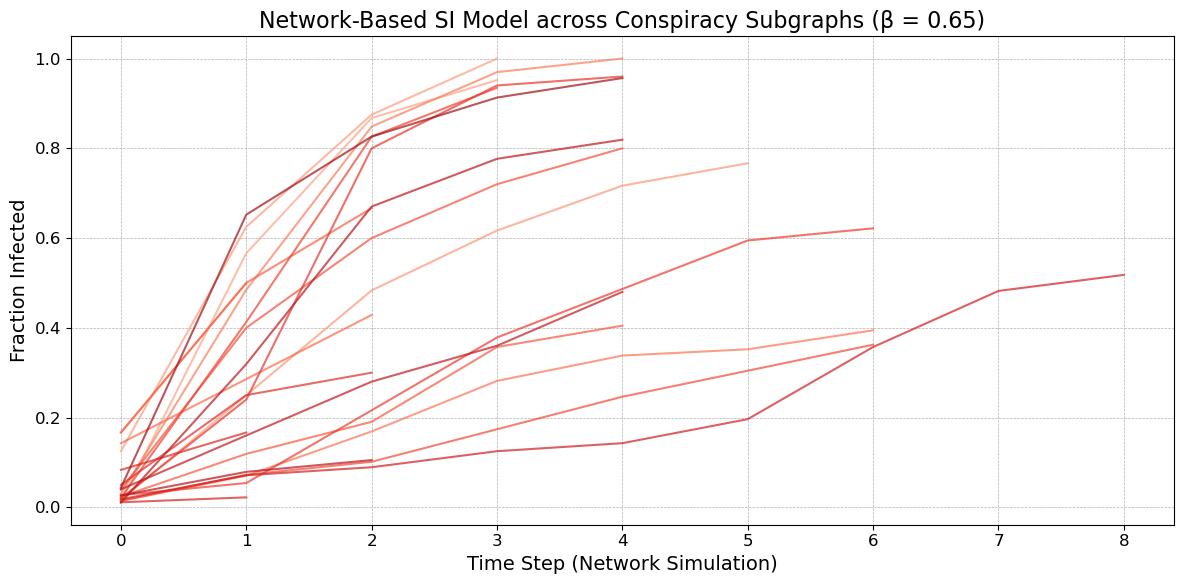

/var/folders/vf/_6h12gpn5_15tp2p642gtz5m0000gn/T/ipykernel_53218/538554572.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  red_map = get_cmap("Reds")


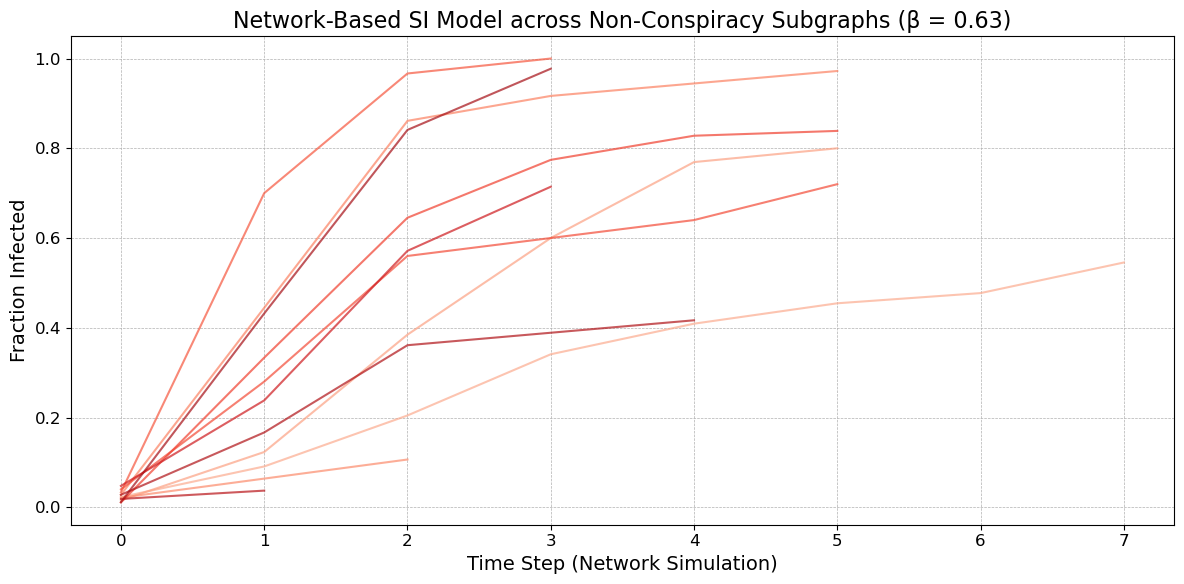

In [71]:
simulate_and_plot_network(conspiracy_node_paths, beta=0.65, title="Network-Based SI Model across Conspiracy Subgraphs (β = 0.65)")
simulate_and_plot_network(nonconspiracy_node_paths, beta=0.63, title="Network-Based SI Model across Non-Conspiracy Subgraphs (β = 0.63)")

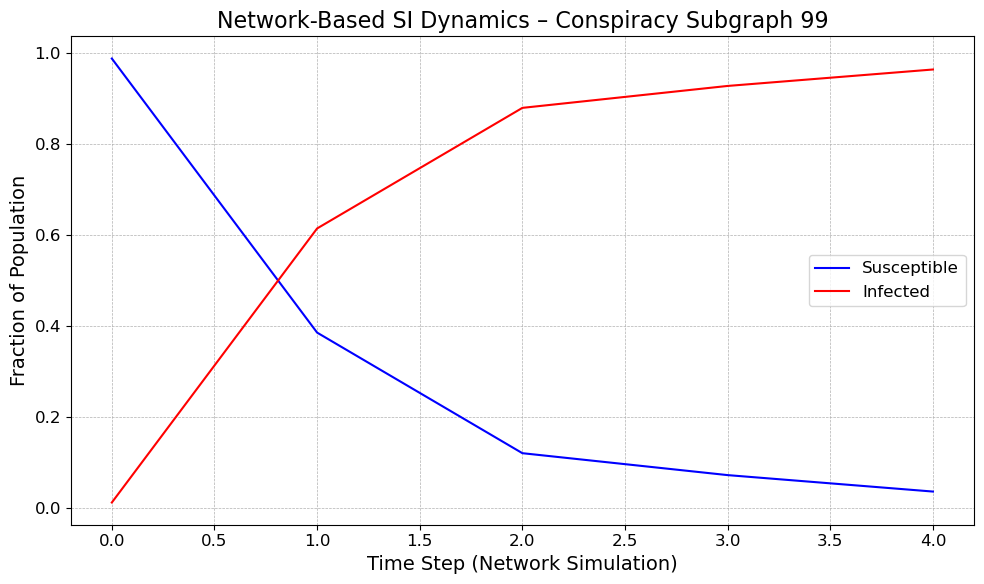

In [72]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# Load data
node_path = '5G-Graphs/99/nodes.csv'
edge_path = '5G-Graphs/99/edges.txt'
beta = 0.65  # Transmission probability per edge

# Read nodes and edges
df = pd.read_csv(node_path)
df = df.dropna(subset=['time'])
df['id'] = df['id'].astype(str)
G = nx.read_edgelist(edge_path, create_using=nx.DiGraph, nodetype=str)
nx.set_node_attributes(G, df.set_index('id').to_dict('index'))

# Find initial infected node
initial_time = df['time'].min()
initial_node = df[df['time'] == initial_time]['id'].iloc[0]

# Network SI simulation (tracks both S and I)
def simulate_SI_network(G, beta, initial_infected):
    N = len(G)
    infected = set([initial_infected])
    susceptible = set(G.nodes()) - infected

    I_frac = [len(infected) / N]
    S_frac = [len(susceptible) / N]

    while susceptible:
        new_infected = set()
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and random.random() < beta:
                    new_infected.add(neighbor)
        if not new_infected:
            break
        infected.update(new_infected)
        susceptible -= new_infected
        I_frac.append(len(infected) / N)
        S_frac.append(len(susceptible) / N)

    return S_frac, I_frac

# Run simulation
S_series, I_series = simulate_SI_network(G, beta, initial_node)
t_steps = np.arange(len(I_series))

# Plot both S and I
plt.figure(figsize=(10, 6))
plt.plot(t_steps, S_series, label='Susceptible', color='blue')
plt.plot(t_steps, I_series, label='Infected', color='red')
plt.xlabel("Time Step (Network Simulation)")
plt.ylabel("Fraction of Population")
plt.title("Network-Based SI Dynamics – Conspiracy Subgraph 99")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


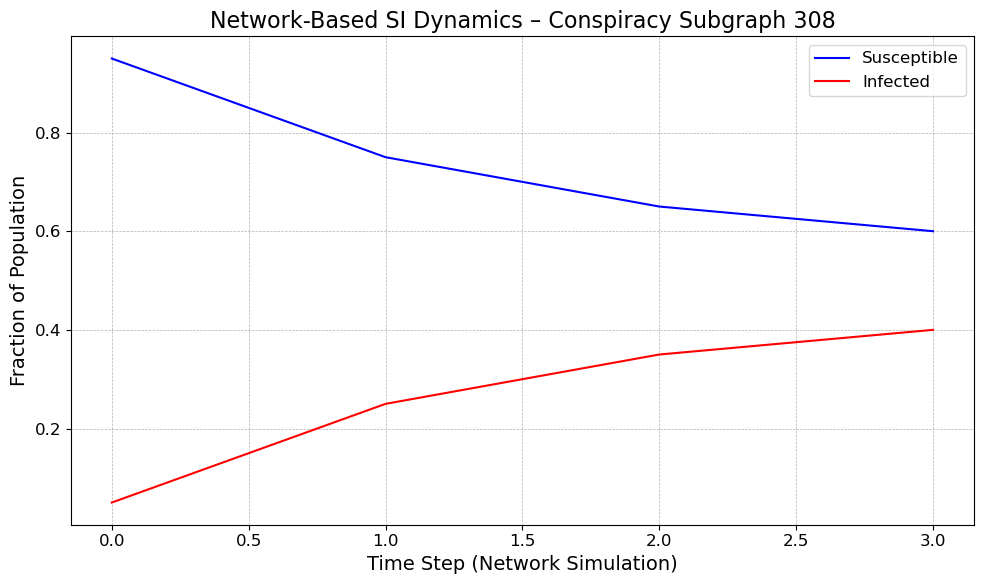

In [73]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# Load data
node_path = '5G-Graphs/308/nodes.csv'
edge_path = '5G-Graphs/308/edges.txt'
beta = 0.65  # Transmission probability per edge

# Read nodes and edges
df = pd.read_csv(node_path)
df = df.dropna(subset=['time'])
df['id'] = df['id'].astype(str)
G = nx.read_edgelist(edge_path, create_using=nx.DiGraph, nodetype=str)
nx.set_node_attributes(G, df.set_index('id').to_dict('index'))

# Find initial infected node
initial_time = df['time'].min()
initial_node = df[df['time'] == initial_time]['id'].iloc[0]

# Network SI simulation (tracks both S and I)
def simulate_SI_network(G, beta, initial_infected):
    N = len(G)
    infected = set([initial_infected])
    susceptible = set(G.nodes()) - infected

    I_frac = [len(infected) / N]
    S_frac = [len(susceptible) / N]

    while susceptible:
        new_infected = set()
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and random.random() < beta:
                    new_infected.add(neighbor)
        if not new_infected:
            break
        infected.update(new_infected)
        susceptible -= new_infected
        I_frac.append(len(infected) / N)
        S_frac.append(len(susceptible) / N)

    return S_frac, I_frac

# Run simulation
S_series, I_series = simulate_SI_network(G, beta, initial_node)
t_steps = np.arange(len(I_series))

# Plot both S and I
plt.figure(figsize=(10, 6))
plt.plot(t_steps, S_series, label='Susceptible', color='blue')
plt.plot(t_steps, I_series, label='Infected', color='red')
plt.xlabel("Time Step (Network Simulation)")
plt.ylabel("Fraction of Population")
plt.title("Network-Based SI Dynamics – Conspiracy Subgraph 308")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()